In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
%matplotlib inline

In [3]:
# regression: 1 lable range 0-1
train_data = pickle.load( open( "../train_data.p", "rb" ) )
train_labels = pickle.load( open( "../train_labels.p", "rb" ) )
test_data = pickle.load( open( "../test_data.p", "rb" ) )
test_labels = pickle.load( open( "../test_labels.p", "rb" ) )
val_data = pickle.load( open( "../val_data.p", "rb" ) )
val_labels = pickle.load( open( "../val_labels.p", "rb" ) )


In [29]:
# classification:  21 labels one hot, 4 features
train_data = pickle.load( open( "../train_data2.p", "rb" ) )
train_labels = pickle.load( open( "../train_labels2.p", "rb" ) )
test_data = pickle.load( open( "../test_data2.p", "rb" ) )
test_labels = pickle.load( open( "../test_labels2.p", "rb" ) )
val_data = pickle.load( open( "../val_data2.p", "rb" ) )
val_labels = pickle.load( open( "../val_labels2.p", "rb" ) )


In [43]:
# get subset of 10 samples
subset_train_data = train_data[0:10000]
subset_train_labels = train_labels[0:10000]

In [51]:
# Training Parameters
# learning_rate = 0.001 # optimize this
learning_rate = 0.1
training_steps = 100000
batch_size = 1 # 128
display_step = 5000

In [52]:
# Network Parameters
num_input = 4
    # 28 # MNIST data input (img shape: 28*28)
timesteps = 23
    # 28 # timesteps
num_hidden = 32 # ?
    # 10 # hidden layer num of features
num_classes = 21 # figure out how to do regression
    # 10 # MNIST total classes (0-9 digits)

In [53]:
#this resets the graph - re-run tensor-flow specific things after it
tf.reset_default_graph() 

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of forward + backward cells
    'out': tf.get_variable("my_int_variable", [2*num_hidden, num_classes],
  initializer=tf.glorot_uniform_initializer(seed = 23))
#     tf.Variable(tf.random_normal([2*num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}




def BiRNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, num_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, num_input)
    x = tf.unstack(x, timesteps, 1)

    # Define lstm cells with tensorflow
    # Forward direction cell
    lstm_fw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=0.20)
    # Backward direction cell
    lstm_bw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=0.20)

    # Get lstm cell output
    try:
        outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                              dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        outputs = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                        dtype=tf.float32)

    # Linear activation, using rnn inner loop last output then sigmoid result to get output in range [0,1]

    # no sigmoid
#     print(len(outputs))
#     print(outputs[-1])
#     1/0
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
    
    # sigmoid
#     return tf.nn.sigmoid(tf.matmul(outputs[-1], weights['out']) + biases['out'])




prediction = BiRNN(X, weights, biases)


# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=Y))
# loss_op = tf.reduce_mean(tf.losses.mean_squared_error(labels=Y, predictions=prediction))

# try reduce mean sq without using built in mse fn
# loss_op = tf.reduce_mean(tf.square(Y - prediction))


# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  # switch to adam optimizer
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
# prediction = tf.nn.softmax(prediction)
prediction = tf.argmax(tf.nn.softmax(prediction), 1)


# correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
correct_pred = tf.equal(prediction, tf.argmax(Y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# accuracy = tf.reduce_mean(tf.losses.mean_squared_error(Y, prediction))
# accuracy = tf.reduce_mean(abs(Y-prediction))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [54]:
def get_batch(batch_size, x, y):
    i = np.random.randint(0,x.shape[0], size=(batch_size))
    return np.array(x[i]), np.array(y[i])

In [55]:
train_data = subset_train_data
train_labels = subset_train_labels
val_data = subset_train_data
val_labels = subset_train_labels


# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = get_batch(batch_size, train_data, train_labels)
        # Reshape data to get 28 seq of 28 elements
#         batch_x = batch_x.reshape((batch_size, timesteps, num_input))
#         batch_y = batch_y.reshape((batch_size, num_classes))
        
        # Run optimization op (backprop)
        sess.run([train_op, loss_op, prediction], feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
#             loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})            

            loss = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
            
            #val accuracy
            acc = 1



#             val_preds = []
            accs = []
            for i in range(val_labels.shape[0]/batch_size):
                val_labels = val_labels.reshape((val_labels.shape[0], num_classes))
                x = val_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
                y = val_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
#                 val_preds.append(sess.run(prediction, feed_dict={X: x}))      
                accs.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
            acc = np.mean(accs)

            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Validation Accuracy= " + \
                     "{:.3f}".format(acc))
        
    
    
    
    
#             preds = sess.run(accuracy, feed_dict={X: batch_x})            
#             print preds
            
#             print batch_y

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist val images
    accs = []
    val_preds = []
    for i in range(val_labels.shape[0]/batch_size):
        val_labels = val_labels.reshape((val_labels.shape[0], num_classes))
        x = val_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
        y = val_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
        val_preds.append(sess.run(prediction, feed_dict={X: x}))      
        accs.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
    
    l = np.mean(accs)
    print("Loss = " + "{:.4f}".format(l))

Step 1, Minibatch Loss= 0.4436, Validation Accuracy= 0.080
Step 5000, Minibatch Loss= 3.6240, Validation Accuracy= 0.091
Step 10000, Minibatch Loss= 3.0743, Validation Accuracy= 0.158
Step 15000, Minibatch Loss= 2.1626, Validation Accuracy= 0.074
Step 20000, Minibatch Loss= 4.0818, Validation Accuracy= 0.158
Step 25000, Minibatch Loss= 2.0442, Validation Accuracy= 0.091
Step 30000, Minibatch Loss= 3.1688, Validation Accuracy= 0.158
Step 35000, Minibatch Loss= 2.5251, Validation Accuracy= 0.091
Step 40000, Minibatch Loss= 3.1072, Validation Accuracy= 0.158
Step 45000, Minibatch Loss= 3.0396, Validation Accuracy= 0.158
Step 50000, Minibatch Loss= 2.2267, Validation Accuracy= 0.158
Step 55000, Minibatch Loss= 2.4838, Validation Accuracy= 0.158
Step 60000, Minibatch Loss= 3.9616, Validation Accuracy= 0.088
Step 65000, Minibatch Loss= 3.5226, Validation Accuracy= 0.158
Step 70000, Minibatch Loss= 3.2470, Validation Accuracy= 0.158
Step 75000, Minibatch Loss= 3.0748, Validation Accuracy= 0.1

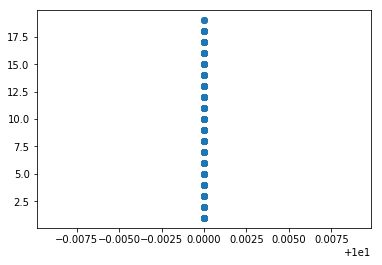

In [56]:
preds = [v[0] for v in val_preds]
plt.scatter(preds, np.argmax(val_labels, axis=1), alpha=0.2)
plt.show()